# 2022-04-28 • Interpolate N = 30 .. 6000

The N = 30 case had a fixed firing rate for the input neurons (of 20 Hz).  
We'll now also give it the lognormal (with mean 4 Hz) firing rate distribution.

We must introduce a new concept / parameter: the desired **stimulation rate** of the input neurons.
It is a product of average firing rate and 'stimulation' (synaptic conductance increase, Δg) per spike.
Given that average spike rate is fixed (namely 4 Hz), we use this paramter to calculate Δg.

A sensible value for it is taken from the previous (N = 6600) notebook
where Δg_exc was 0.4 nS and the Δg_multiplier was 0.066.

We'll thus choose `avg_stimulation_rate__exc` to be 0.4 nS * 0.066 * 4 Hz, or **0.1 nS/second**.
Our inhibitory inputs have 4x the strength, so `avg_stimulation_rate__inh` will be **0.4 nS/second**.

The actual stimulation rate for each input neuron will vary from these, as their firing rates are not 4 Hz, but rather distributed lognormally somewhere around that.

## Setup

In [1]:
#

In [2]:
using Revise

In [3]:
using MyToolbox

In [4]:
using VoltageToMap

## Params

In [16]:
N_excs = [
    4,   # => N_inh = 1
    17,  # Same as in `previous_N_30_input`.
    80,
    320,
    1280,
    5200,
];

In [17]:
get_params(N_exc) = ExperimentParams(
    sim = SimParams(
        duration = 10 * minutes,
        imaging = get_VI_params_for(cortical_RS, spike_SNR = Inf),
        input = PoissonInputParams(; N_exc),
    ),
);

In [18]:
param_sets = get_params.(N_excs);

In [19]:
dumps(param_sets[1])

ExperimentParams
  rngseed: 22022022
  sim: SimParams
    duration: 600.0
    Δt: 0.0001
    num_timesteps: 6000000
    rngseed: 0
    input: PoissonInputParams
      N_unconn: 100
      N_exc: 4
      N_inh: 1
      N_conn: 5
      N: 105
      spike_rates: LogNormal
        μ: 1.08629
        σ: 0.774597
    synapses: SynapseParams
      avg_stim_rate_exc: 1.0e-10
      avg_stim_rate_inh: 4.0e-10
      E_exc: 0.0
      E_inh: -0.065
      g_t0: 0.0
      τ: 0.007
    izh_neuron: IzhikevichParams
      C: 1.0e-10
      k: 7.0e-7
      v_rest: -0.06
      v_thr: -0.04
      a: 30.0
      b: -2.0e-9
      v_peak: 0.035
      v_reset: -0.05
      Δu: 1.0e-10
      v_t0: -0.06
      u_t0: 0.0
    imaging: VoltageImagingParams
      spike_SNR: Inf
      spike_SNR_dB: Inf
      spike_height: 0.095
      σ_noise: 0.0
  conntest: ConnTestParams
    STA_window_length: 0.1
    num_shuffles: 100
    rngseed: 22022022
  evaluation: EvaluationParams
    α: 0.05
    num_tested_neurons_per_group: 40

## Run

In [85]:
perfs = Vector()
for params in param_sets
    @show params.sim.input.N_conn
    perf = performance_for(params)
    @show perf
    push!(perfs, perf)
    println()
end

params.sim.input.N_conn = 5
Running simulation: 100%|███████████████████████████████| Time: 0:00:14
perf = (TPR_exc = 1.0, TPR_inh = 1.0, FPR = 0.07499999999999996)

params.sim.input.N_conn = 21
Running simulation: 100%|███████████████████████████████| Time: 0:00:12
perf = (TPR_exc = 1.0, TPR_inh = 1.0, FPR = 0.0)

params.sim.input.N_conn = 100
Running simulation: 100%|███████████████████████████████| Time: 0:00:12
perf = (TPR_exc = 1.0, TPR_inh = 0.85, FPR = 0.0)

params.sim.input.N_conn = 400
Running simulation: 100%|███████████████████████████████| Time: 0:00:18
perf = (TPR_exc = 0.925, TPR_inh = 0.425, FPR = 0.09999999999999998)

params.sim.input.N_conn = 1600
Running simulation: 100%|███████████████████████████████| Time: 0:00:45
perf = (TPR_exc = 0.525, TPR_inh = 0.225, FPR = 0.050000000000000044)

params.sim.input.N_conn = 6500
Running simulation: 100%|███████████████████████████████| Time: 0:02:32
perf = (TPR_exc = 0.05, TPR_inh = 0.5, FPR = 0.15000000000000002)



## Plot results

In [10]:
import PyPlot

In [11]:
using VoltageToMap.Plot

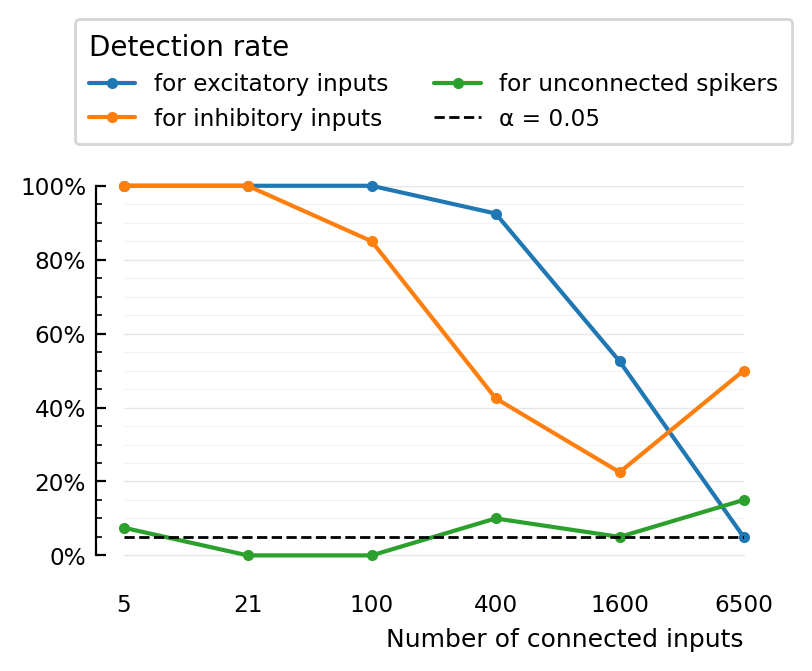

In [86]:
xlabels = [p.sim.input.N_conn for p in param_sets]
xticks = [1:length(xlabels);]
plot_detection_rate(detection_rate; kw...) = plot(
    xticks,
    detection_rate,
    ".-";
    ylim=(0, 1),
    xminorticks=false,
    clip_on=false,
    kw...
)
ax = plot_detection_rate([p.TPR_exc for p in perfs], label="for excitatory inputs")
     plot_detection_rate([p.TPR_inh for p in perfs], label="for inhibitory inputs")
     plot_detection_rate([p.FPR for p in perfs], label="for unconnected spikers")

@unpack α = param_sets[1].evaluation
ax.axhline(α, color="black", zorder=3, lw=1, linestyle="dashed", label=f"α = {α:.3G}")

# We don't use our `set`, as that undoes our `xminorticks=false` command (bug).
ax.set_xticks(xticks, xlabels)
ax.set_xlabel("Number of connected inputs")
ax.yaxis.set_major_formatter(PyPlot.matplotlib.ticker.PercentFormatter(xmax=1))
ax.xaxis.grid(false)
ax.tick_params(bottom=false)
ax.spines["bottom"].set_visible(false)
l = ax.legend(title="Detection rate", ncol=2, loc="lower center", bbox_to_anchor=(0.5, 1.1));
l._legend_box.align = "left";

- We see monotonic breakdown in excitatory connection detectability.
- Same for inhibitory, except it's not monotonic. Fluke due to sampling?
- This plot must be improved with multiple simulations per condition rather than just single point.  
  (takes a while to run multiple 10' N=6500 sims though).